# Challenge

## Imports

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
import warnings

warnings.filterwarnings(action='once')

C:\Users\p-d-const127b\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\p-d-const127b\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\p-d-const127b\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\p-d-const127b\Anaconda3\lib\site-packages\tensorflow\python\framework\dty

In [2]:
#Loading data
data = os.path.join("Resources", "charity_data.csv")

# Import our input dataset
rawdata_df = pd.read_csv(data)
rawdata_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Checking shape
rawdata_df.shape

(34299, 12)

In [4]:
# Checking types
rawdata_df.dtypes

EIN                        int64
NAME                      object
APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
STATUS                     int64
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

## Cleaning data

Within this dataset are a number of columns that capture metadata about each organization such as the following:- EIN and NAME—Identification columns:
- EIN and NAME—Identification columns
- APPLICATION_TYPE—Alphabet Soup application type
- AFFILIATION—Affiliated sector of industry
- CLASSIFICATION—Government organization classification
- USE_CASE—Use case for funding
- ORGANIZATION—Organization type
- STATUS—Active status
- INCOME_AMT—Income classification
- SPECIAL_CONSIDERATIONS—Special consideration for application
- ASK_AMT—Funding amount requested
- IS_SUCCESSFUL—Was the money used effectively

Columns to drop as they have no impact on the model:
- EIN and NAME—Identification columns
- APPLICATION_TYPE—Alphabet Soup application type
    > informational data only

Data to sort and then drop:
 - STATUS—Active
    > status must be egal to 1 as we are focus on currently active companies

In [5]:
# Cleaning the dataset
cleandata_df = rawdata_df.loc[rawdata_df["STATUS"]==1]
cleandata_df = cleandata_df.drop(columns=["EIN","NAME","APPLICATION_TYPE","STATUS"])

cleandata_df.head()

,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,Independent,C1000,ProductDev,Association,0,N,5000,1
1,Independent,C2000,Preservation,Co-operative,1-9999,N,108590,1
2,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0
3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
4,Independent,C1000,Heathcare,Trust,100000-499999,N,142590,1


In [6]:
# Checking shape
cleandata_df.shape

(34294, 8)

In [7]:
# Checking types
cleandata_df.dtypes

AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

### Bucketing/Encoding

In [8]:
# Generate our categorical variable list
charity_cat = cleandata_df.dtypes[cleandata_df.dtypes == "object"].index.tolist()
charity_cat

['AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [9]:
# Check the number of unique values in each column
cleandata_df[charity_cat].nunique()

AFFILIATION                6
CLASSIFICATION            71
USE_CASE                   5
ORGANIZATION               4
INCOME_AMT                 9
SPECIAL_CONSIDERATIONS     2
dtype: int64

Only "CLASSIFICATION" columns need to be bucketed as its unique values exceed the commonly used limit of 10.

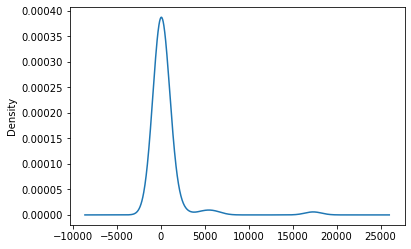

In [10]:
# Visualize the value counts
classification_counts = rawdata_df.CLASSIFICATION.value_counts()
classification_counts.plot.density()

According to the density plot, the most common unique values have more than about 1,500 instances within the dataset. That will be our bucket limit.

In [11]:
# Determine which values to replace
replace_classification = list(classification_counts[classification_counts < 1500].index)

# Replace in DataFrame
for classification in replace_classification:
    cleandata_df.CLASSIFICATION = cleandata_df.CLASSIFICATION.replace(classification,"Other")

# Check to make sure binning was successful
cleandata_df.CLASSIFICATION.value_counts()

C1000    17323
C2000     6073
C1200     4837
Other     2261
C3000     1918
C2100     1882
Name: CLASSIFICATION, dtype: int64

### Encoding

In [12]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(cleandata_df[charity_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(charity_cat)
encode_df.head()

,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
pd.options.display.max_columns = 999

In [14]:
encode_df.head()

,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
# Merge one-hot encoded features and drop the originals
encodedata_df = cleandata_df.merge(encode_df,left_index=True, right_index=True)
encodedata_df = encodedata_df.drop(charity_cat,1)
encodedata_df.head()

,ASK_AMT,IS_SUCCESSFUL,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,5000,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6692,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Checking types (final)
encodedata_df.dtypes

ASK_AMT                           int64
IS_SUCCESSFUL                     int64
AFFILIATION_CompanySponsored    float64
AFFILIATION_Family/Parent       float64
AFFILIATION_Independent         float64
AFFILIATION_National            float64
AFFILIATION_Other               float64
AFFILIATION_Regional            float64
CLASSIFICATION_C1000            float64
CLASSIFICATION_C1200            float64
CLASSIFICATION_C2000            float64
CLASSIFICATION_C2100            float64
CLASSIFICATION_C3000            float64
CLASSIFICATION_Other            float64
USE_CASE_CommunityServ          float64
USE_CASE_Heathcare              float64
USE_CASE_Other                  float64
USE_CASE_Preservation           float64
USE_CASE_ProductDev             float64
ORGANIZATION_Association        float64
ORGANIZATION_Co-operative       float64
ORGANIZATION_Corporation        float64
ORGANIZATION_Trust              float64
INCOME_AMT_0                    float64
INCOME_AMT_1-9999               float64


## Preparing the train and test data

In [17]:
# Remove "IS_SUCCESSFUL" target from features data
y = encodedata_df.IS_SUCCESSFUL
X = encodedata_df.drop(columns=["IS_SUCCESSFUL"])

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Scale the data

In [18]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Define, build and train the model

In [19]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = len(X_train_scaled[0])*2

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
25716/25716 [==============================] - 1s 34us/sample - loss: 0.6905 - acc: 0.5565
Epoch 2/50
25716/25716 [==============================] - 1s 33us/sample - loss: 0.6853 - acc: 0.5658
Epoch 3/50
25716/25716 [==============================] - 1s 30us/sample - loss: 0.6840 - acc: 0.5680
Epoch 4/50
25716/25716 [==============================] - 1s 37us/sample - loss: 0.6832 - acc: 0.5679
Epoch 5/50
25716/25716 [==============================] - 1s 37us/sample - loss: 0.6833 - acc: 0.5681
Epoch 6/50
25716/25716 [==============================] - 1s 36us/sample - loss: 0.6830 - acc: 0.5677
Epoch 7/50
25716/25716 [==============================] - 1s 38us/sample - loss: 0.6822 - acc: 0.5728
Epoch 8/50
25716/25716 [==============================] - 1s 35us/sample -

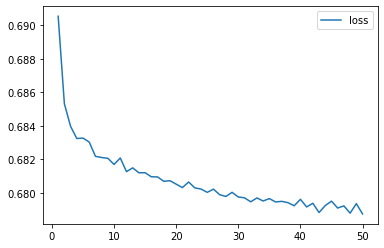

In [20]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

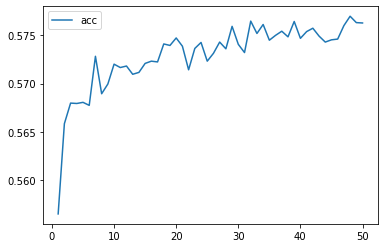

In [21]:
# Plot the accuracy
history_df.plot(y="acc")

### Evaluate the model using the test data


In [22]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8573/8573 - 0s - loss: 0.6852 - acc: 0.5605
Loss: 0.6851853318925251, Accuracy: 0.5604805946350098


## Improving the model

### 1/4 Adding more neurons to the layer

In [23]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = len(X_train_scaled[0])*3

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
25716/25716 [==============================] - 1s 36us/sample - loss: 0.6913 - acc: 0.5521
Epoch 2/50
25716/25716 [==============================] - 1s 32us/sample - loss: 0.6862 - acc: 0.56491s - loss: 0.68
Epoch 3/50
25716/25716 [==============================] - 1s 31us/sample - loss: 0.6850 - acc: 0.5661
Epoch 4/50
25716/25716 [==============================] - 1s 33us/sample - loss: 0.6838 - acc: 0.5682
Epoch 5/50
25716/25716 [==============================] - 1s 35us/sample - loss: 0.6837 - acc: 0.5701
Epoch 6/50
25716/25716 [==============================] - 1s 30us/sample - loss: 0.6830 - acc: 0.5684
Epoch 7/50
25716/25716 [==============================] - 1s 31us/sample - loss: 0.6818 - acc: 0.5712
Epoch 8/50
25716/25716 [==============================] - 1s 30us/sample - loss: 0.6828 - acc: 0.57110s - loss: 0.685
Epoch 9/50
25716/25716 [==============================] - 1s 31us/sample - loss: 0.6822 - acc: 0.5704
Epoch 10/50
25716/25716 [==========================

### 2/4 Adding another hidden layer

In [24]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = len(X_train_scaled[0])*3
hidden_nodes_layer2 = len(X_train_scaled[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
25716/25716 [==============================] - 1s 34us/sample - loss: 0.6896 - acc: 0.5597
Epoch 2/50
25716/25716 [==============================] - 1s 29us/sample - loss: 0.6836 - acc: 0.5687
Epoch 3/50
25716/25716 [==============================] - 1s 29us/sample - loss: 0.6826 - acc: 0.5707
Epoch 4/50
25716/25716 [==============================] - 1s 31us/sample - loss: 0.6819 - acc: 0.5678
Epoch 5/50
25716/25716 [==============================] - ETA: 0s - loss: 0.6813 - acc: 0.5724- ETA: 0s - loss: 0.6823  - 1s 31us/sample - loss: 0.6816 - acc: 0.5717
Epoch 6/50
25716/25716 [==============================] - 1s 30us/sample - loss: 0.6812 - acc: 0.57350s - loss: 0.6804 - acc: 0.575 - ETA: 0s - loss: 0.6823 - acc: 0.56 - ETA: 0s - loss: 0.6826 - a
Epoch 7/50
25716/25716 [==============================] - 1s 30us/sample - loss: 0.6813 - acc: 0.5722
Epoch 8/50
25716/25716 [==============================] - 1s 30us/sample - loss: 0.6807 - acc: 0.57270s - loss: 0.6786 - ac
Ep

### 3/4 Increasing the number of epochs 

In [25]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = len(X_train_scaled[0])*3
hidden_nodes_layer2 = len(X_train_scaled[0])


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
25716/25716 [==============================] - 1s 32us/sample - loss: 0.6885 - acc: 0.5580
Epoch 2/100
25716/25716 [==============================] - 1s 28us/sample - loss: 0.6832 - acc: 0.5647
Epoch 3/100
25716/25716 [==============================] - 1s 29us/sample - loss: 0.6828 - acc: 0.5693
Epoch 4/100
25716/25716 [==============================] - 1s 28us/sample - loss: 0.6819 - acc: 0.57140s - loss: 0.6759 - acc: 0.59 - ETA: 0s - loss: 0.6758 -
Epoch 5/100
25716/25716 [==============================] - 1s 28us/sample - loss: 0.6818 - acc: 0.5716
Epoch 6/100
25716/25716 [==============================] - 1s 29us/sample - loss: 0.6809 - acc: 0.5730
Epoch 7/100
25716/25716 [==============================] - 1s 29us/sample - loss: 0.6810 - acc: 0.5723
Epoch 8/100
25716/25716 [==============================] - 1s 28us/sample - loss: 0.6807 - acc: 0.5733
Epoch 9/100
25716/25716 [==============================] - 1s 28us/sample - loss: 0.6808 - acc: 0.5747
Epoch 10/100
2571

### 4/4 Removing some noisy data

#### Removing potential noisy data

In [26]:
encodedata_df.head()

,ASK_AMT,IS_SUCCESSFUL,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,5000,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6692,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
encodedata_bis_df=encodedata_df.copy()
encodedata_bis_df.shape

(34289, 34)

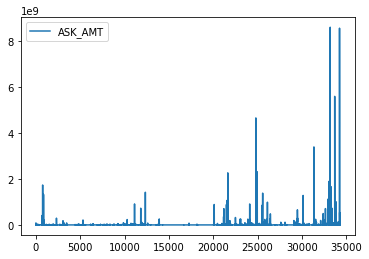

In [28]:
# Checking repartion of data by amount asked
encodedata_bis_df.plot(y="ASK_AMT")

In [29]:
# Cut the amount asked by spending ranges.
amount_asked=encodedata_bis_df["ASK_AMT"]
spending_bins = [0, 2000000, 4000000, 6000000, 8000000, 10000000]
group_names = ["<2M", "2M-4M", "4M-6M", "6M-8M", ">8M"]
amount_asked.groupby(pd.cut(amount_asked, spending_bins)).count()

ASK_AMT
(0, 2000000]           33198
(2000000, 4000000]       358
(4000000, 6000000]       180
(6000000, 8000000]       100
(8000000, 10000000]       42
Name: ASK_AMT, dtype: int64

We are going to keep only requests with amount asked below 2M$ as they represent about 97% of the total requests received

In [30]:
encodedata_bis_df=encodedata_bis_df.loc[encodedata_bis_df["ASK_AMT"]<=2000000]
encodedata_bis_df.shape

(33198, 34)

#### Preparing the train and test data + Scale the data

In [31]:
# Remove "IS_SUCCESSFUL" target from features data
y_bis = encodedata_bis_df.IS_SUCCESSFUL
X_bis = encodedata_bis_df.drop(columns=["IS_SUCCESSFUL"])

# Split training/test datasets
X_bis_train, X_bis_test, y_bis_train, y_bis_test = train_test_split(X_bis, y_bis, random_state=42, stratify=y_bis)

In [32]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_bis_scaler = scaler.fit(X_bis_train)

# Scale the data
X_bis_train_scaled = X_bis_scaler.transform(X_bis_train)
X_bis_test_scaled = X_bis_scaler.transform(X_bis_test)

#### Define, build, train and evaluate the model


In [33]:
# Define the model - deep neural net
number_input_features = len(X_bis_train_scaled[0])
hidden_nodes_layer1 = len(X_bis_train_scaled[0])*3
hidden_nodes_layer2 = len(X_bis_train_scaled[0])


nn_bis = tf.keras.models.Sequential()

# First hidden layer
nn_bis.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn_bis.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_bis.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_bis.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_bis.fit(X_bis_train_scaled, y_bis_train, epochs=100)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_bis.evaluate(X_bis_test_scaled,y_bis_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
24898/24898 [==============================] - 1s 33us/sample - loss: 0.6891 - acc: 0.5573
Epoch 2/100
24898/24898 [==============================] - 1s 32us/sample - loss: 0.6843 - acc: 0.5651
Epoch 3/100
24898/24898 [==============================] - 1s 31us/sample - loss: 0.6828 - acc: 0.5671
Epoch 4/100
24898/24898 [==============================] - 1s 31us/sample - loss: 0.6825 - acc: 0.5688
Epoch 5/100
24898/24898 [==============================] - 1s 33us/sample - loss: 0.6814 - acc: 0.5719
Epoch 6/100
24898/24898 [==============================] - 1s 36us/sample - loss: 0.6809 - acc: 0.5689
Epoch 7/100
24898/24898 [==============================] - 1s 32us/sample - loss: 0.6806 - acc: 0.5715
Epoch 8/100
24898/24898 [==============================] - 1s 32us/sample - loss: 0.6805 - acc: 0.57230s - loss: 0.6805 - acc: 0.572
Epoch 9/100
24898/24898 [==============================] - 1s 30us/sample - loss: 0.6801 - acc: 0.5725
Epoch 10/100
24898/24898 [=================